Instance Segmentation with Mask R-CNN

While semantic segmentation classifies the pixels to a particlar class, instance segmentation goes further and differentiates between each object of the same class. Refer to the screenshot.

In [1]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random
import time
import os
import subprocess
import requests
import glob

In [2]:
np.random.seed(20)

2. Instance Segmentation with Torchvision Models

Input is list of tensors shape [C,H,W], one for each image and between 0-1

Output as a List[Dict[Tensor]]:
    - boxes (Tensor [N, 4]): the predicted boxes
    - labels (Tensor[N]): predicted labels for each image
    - scores (Tensor[N]) : the scores for each prediction
    - masks (Tensor[N, H, W]): the predicted masks for each instance 0-1 in range

In [3]:
# get the pretrained model from torchvision.models
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(
    weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT
)
_ = model.eval()

 # These are the classes that are available in the COCO-Dataset
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\rdinh/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:16<00:00, 10.9MB/s] 


Create helper functions. random_color_masks() used to fill the predicted-mask with colors. get_predictions() to return final predictions from the model. instance_segmentation_api() to overlay the colored maks over the og image and plot it.

In [4]:
# Assign a color to each detected object mask for visualization
def random_color_masks(image, colors):
    """
    Assigns a random color to each predicted object mask.

    Parameters:
        image (numpy.ndarray): Binary mask where detected object pixels are 1.
        colors (list): List of available colors for masks.

    Returns:
        numpy.ndarray: Colored mask of the same shape as the input.
    """
    # Create empty color channels
    r, g, b = np.zeros_like(image, dtype=np.uint8), np.zeros_like(image, dtype=np.uint8), np.zeros_like(image, dtype=np.uint8)

    # Assign a random color to the mask
    r[image == 1], g[image == 1], b[image == 1] = colors[random.randint(0, len(colors) - 1)]

    # Stack the channels to create a colored mask
    return np.stack([r, g, b], axis=2)


# Get predictions (masks, bounding boxes, and class labels) from the model
def get_prediction(img_path, threshold):
    """
    Performs object instance segmentation on an image.

    Parameters:
        img_path (str): Path to the input image.
        threshold (float): Confidence threshold for filtering predictions.

    Returns:
        tuple: (masks, bounding boxes, class labels)
    """
    # Load image using PIL
    img = Image.open(img_path)

    # Convert image to a PyTorch tensor
    img_tensor = T.ToTensor()(img)

    # Perform inference with the model in no-grad mode to save memory
    with torch.no_grad():
        pred = model([img_tensor])

    # Extract predictions and convert to NumPy arrays
    pred_data = pred[0]
    scores = pred_data['scores'].detach().cpu().numpy()
    labels = pred_data['labels'].detach().cpu().numpy()
    boxes = pred_data['boxes'].detach().cpu().numpy()
    masks = (pred_data['masks'] > 0.5).squeeze().detach().cpu().numpy()

    # Get index of last prediction above the threshold
    valid_indices = scores > threshold
    if not np.any(valid_indices):
        return [], [], []

    # Select predictions that meet the confidence threshold
    pred_boxes = [[(b[0], b[1]), (b[2], b[3])] for b in boxes[valid_indices]]
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in labels[valid_indices]]
    masks = masks[valid_indices]

    return masks, pred_boxes, pred_class


# Perform instance segmentation and visualize the result
def instance_segmentation_api(img_path, threshold=0.5):
    """
    Performs instance segmentation on an image and displays the result.

    Parameters:
        img_path (str): Path to the input image.
        threshold (float, optional): Minimum confidence score for valid predictions. Defaults to 0.5.
    """
    # Get segmentation predictions
    masks, boxes, pred_cls = get_prediction(img_path, threshold)

    # Load the image using OpenCV and convert from BGR to RGB
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Calculate rectangle and text thickness based on image size
    rect_th = max(round(sum(img.shape) / 2 * 0.003), 2)
    text_th = max(rect_th - 1, 1)

    # Iterate over detected objects
    for i in range(len(masks)):
        # Get bounding box coordinates
        p1, p2 = (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1]))

        # Generate a random color mask for the object
        rgb_mask = random_color_masks(masks[i], COLORS)

        # Blend mask with original image using weighted sum
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)

        # Select bounding box color based on object class
        color = COLORS[COCO_INSTANCE_CATEGORY_NAMES.index(pred_cls[i])]

        # Draw bounding box around the detected object
        cv2.rectangle(img, p1, p2, color=color, thickness=rect_th)

        # Get text size for label display
        w, h = cv2.getTextSize(pred_cls[i], 0, fontScale=rect_th / 3, thickness=text_th)[0]
        outside = p1[1] - h >= 3  # Determine whether label should be inside or outside box
        p2 = (p1[0] + w, p1[1] - h - 3) if outside else (p1[0] + w, p1[1] + h + 3)

        # Draw filled rectangle as background for the class label
        cv2.rectangle(img, p1, p2, color=color, thickness=-1, lineType=cv2.LINE_AA)

        # Overlay the object class label on the image
        cv2.putText(
            img,
            pred_cls[i],
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            rect_th / 3,
            (255, 255, 255),
            thickness=text_th + 1
        )

    # Display the final image with masks and bounding boxes
    plt.figure(figsize=(20, 17))
    plt.imshow(img)
    plt.axis("off")  # Hide axis labels
    plt.show()

In [5]:
def download_file(url, save_name):
    if not os.path.exists(save_name):
        subprocess.run(['wget', url, '-O', save_name, '-q'])

In [6]:
# Create directory to donwload inference data.
inference_dir = 'inference_data'
os.makedirs(inference_dir, exist_ok=True)

3. Inference

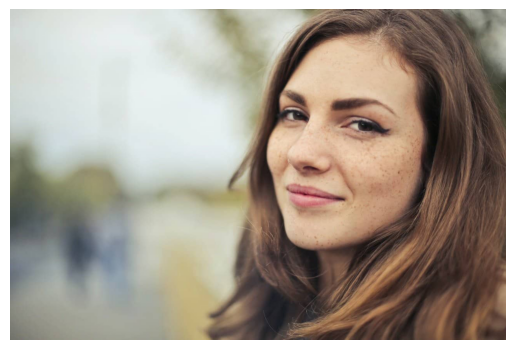

In [7]:
# Download the image and plotting it
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/person-1.jpg',
    os.path.join(inference_dir, 'person.jpg')
)

img = Image.open(os.path.join(inference_dir, 'person.jpg'))
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
# Running inference on the image
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)
with torch.no_grad():
    pred = model([img_tensor])

In [9]:
# Lets look at what the `pred` looks like.
# `pred` is a list of dictionaries, since we had passed a single image, we will get a single-item list
pred[0]

{'boxes': tensor([[ 432.4209,    2.1869, 1280.0001,  851.2471],
         [ 110.5375,   44.9294,  854.3920,  853.0000]]),
 'labels': tensor([1, 1]),
 'scores': tensor([0.9998, 0.1092]),
 'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0014, 0.0013, 0.0012],
           [0.0000, 0.0000, 0.0000,  ..., 0.0015, 0.0014, 0.0013],
           [0.0000, 0.0000, 0.0000,  ..., 0.0016, 0.0015, 0.0014],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.1387, 0.1312, 0.1236],
           [0.0000, 0.0000, 0.0000,  ..., 0.1303, 0.1232, 0.1161],
           [0.0000, 0.0000, 0.0000,  ..., 0.1218, 0.1151, 0.1085]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0

In [10]:
# We will keep only the pixels with values  greater than 0.5 as 1, and set the rest to 0.
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
masks.shape

(2, 853, 1280)

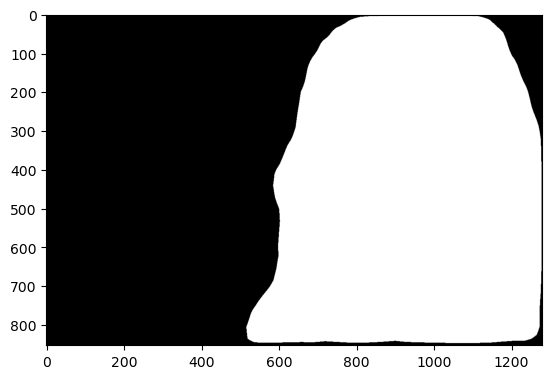

In [11]:
# Let's plot the mask for the `person` class since the 0th mask belongs to `person`
plt.imshow(masks[0], cmap='gray')
plt.show()

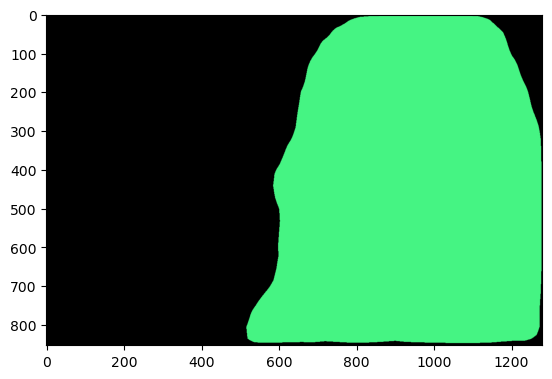

In [17]:
# Let's color the `person` mask using the `random_color_masks` function
mask1 = random_color_masks(masks[0], COLORS)
plt.imshow(mask1)
plt.show()

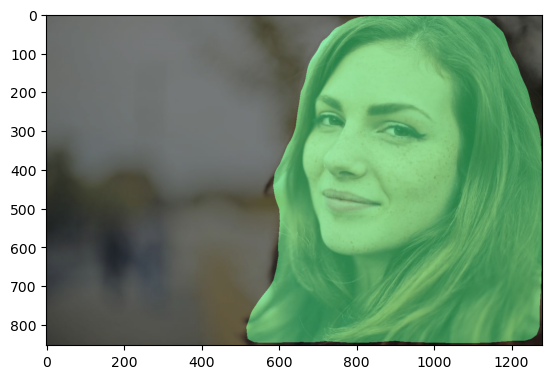

In [18]:
# Let's blend the original and the masked image and plot it.
blend_img = cv2.addWeighted(np.asarray(img), 0.5, mask1, 0.5, 0)

plt.imshow(blend_img)
plt.show()

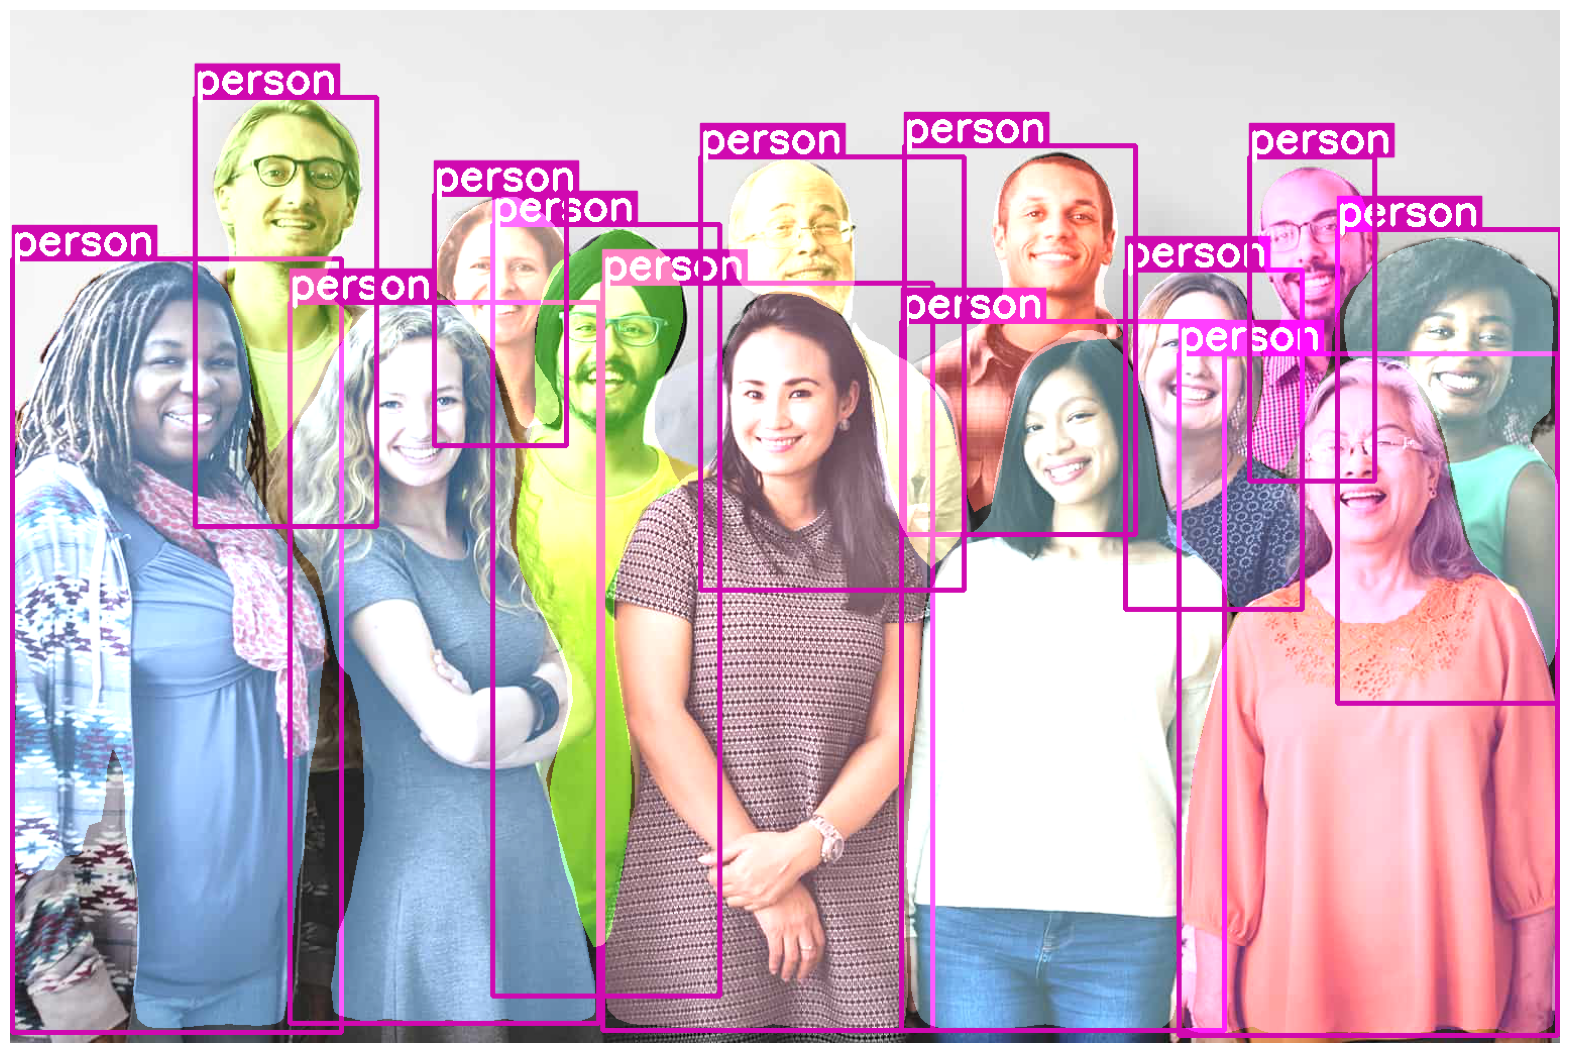

In [20]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/mrcnn_standing_people.jpg',
    os.path.join(inference_dir, 'mrcnn_standing_people.jpg')
)
instance_segmentation_api(os.path.join(inference_dir, 'mrcnn_standing_people.jpg'), 0.75)

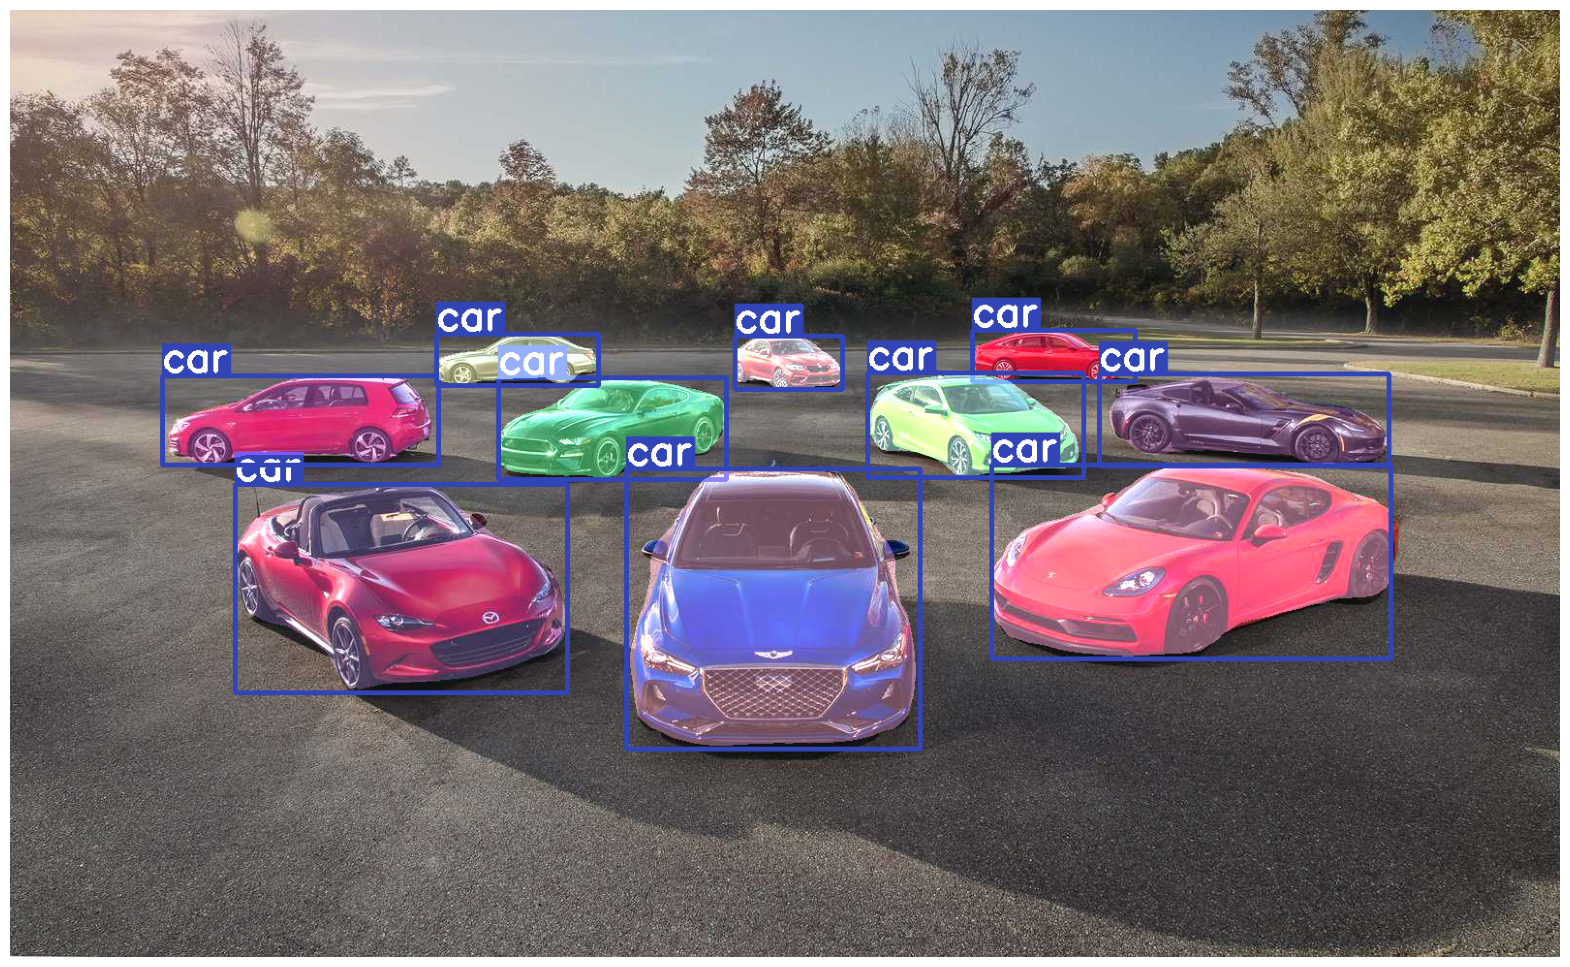

In [21]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/mrcnn_cars-scaled.jpg',
    os.path.join(inference_dir, 'mrcnn_cars.jpg')
)
instance_segmentation_api(os.path.join(inference_dir, 'mrcnn_cars.jpg'), 0.9)

Application: Background blurring

Here we will use the segmentation algorithm to blur the background. The whole concept is broken down into few steps.

    Pick the class we want to keep as foreground (person) and get its mask using the segmentation api. The locations belonging to person-class will be labelled as 1 and the rest as 0.
    Blur the original image.
    Create a new image such that, pixel locations where the mask is 1 is replaced with the original values and the rest with the blurred values.


In [22]:
def pick_person_mask(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    # get the predicted masks and boxes and their corresponding labels
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    # pick the indices belonging to person
    person_ids = [i for i in range(len(pred_cls)) if pred_cls[i]=="person"]
    # pick the masks with the person-ids
    person_masks = masks[person_ids, :, :]
    # create a single mask out of all the instances and clip them
    persons_mask = person_masks.sum(axis=0)
    persons_mask = np.clip(persons_mask, 0,1)
    return persons_mask

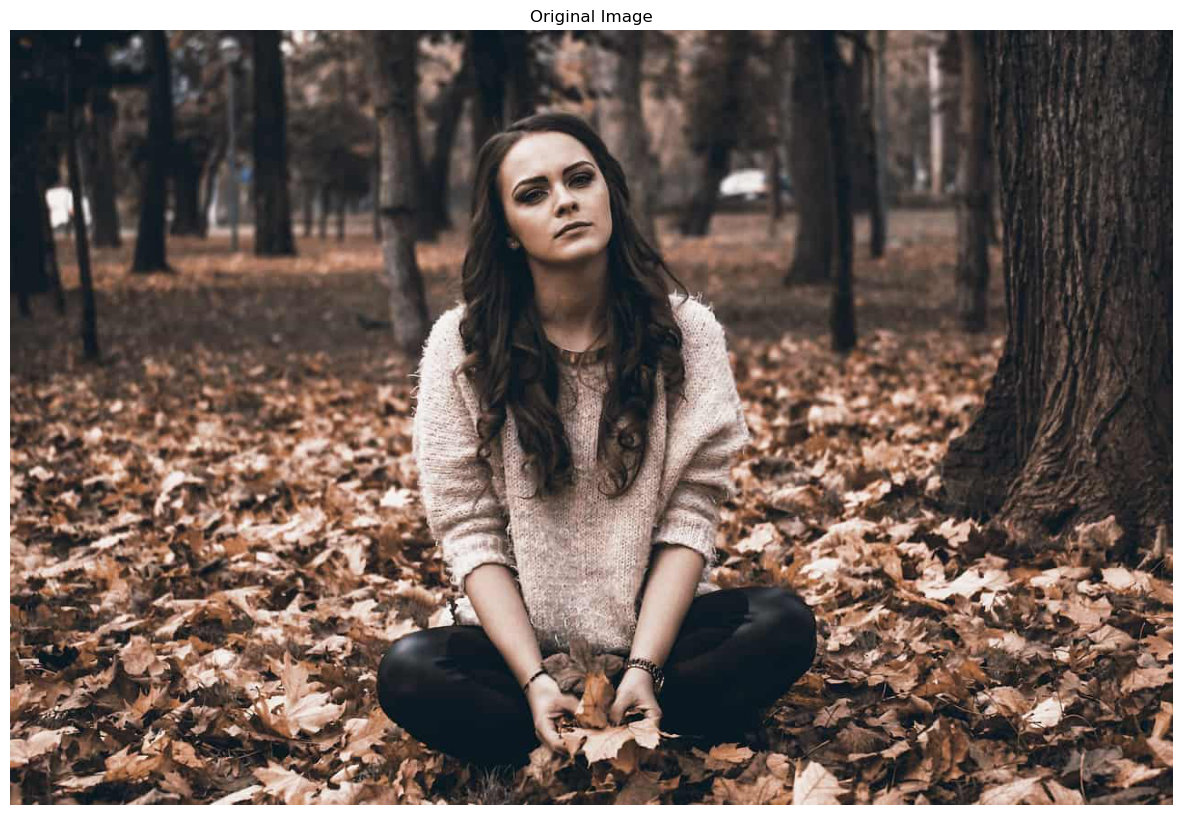

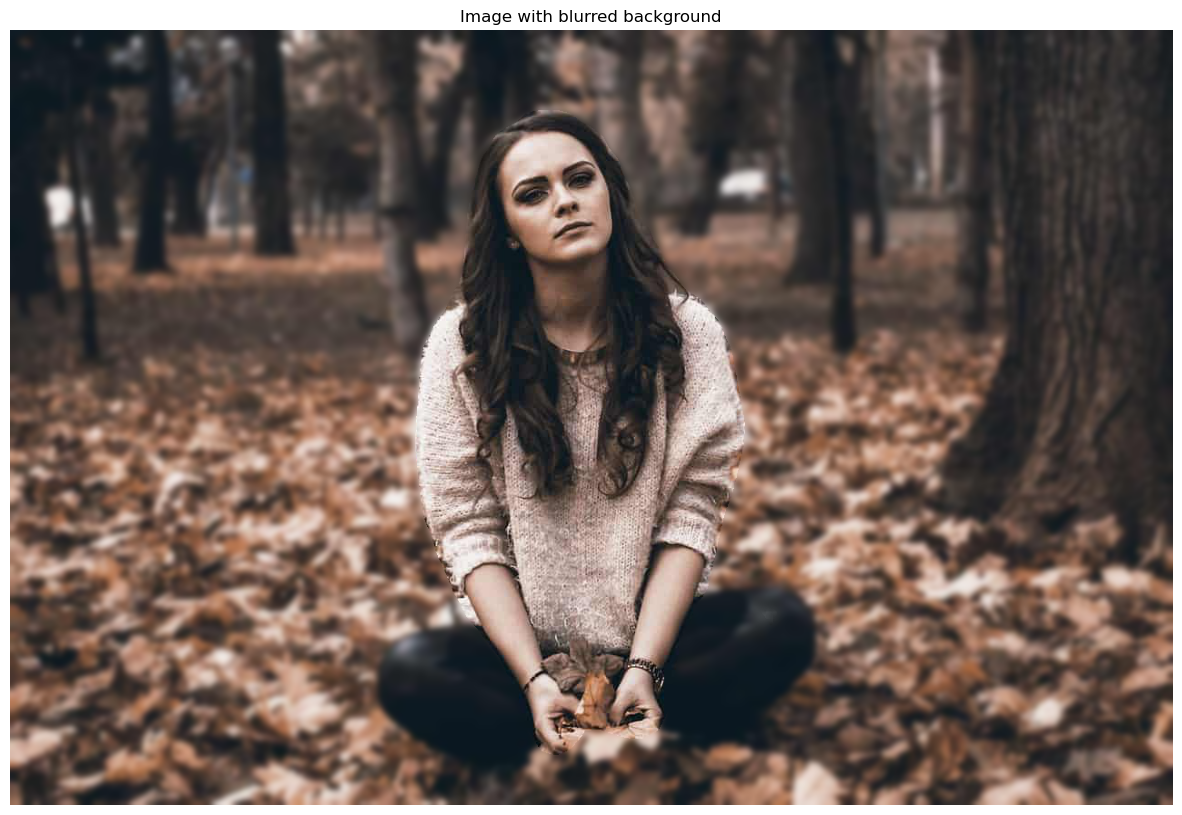

In [23]:
# These are a few images you can play around with

# https://cdn.pixabay.com/photo/2018/03/12/20/57/woman-3220835_1280.jpg
# https://cdn.pixabay.com/photo/2017/02/06/10/54/sad-2042536_1280.jpg
# https://cdn.pixabay.com/photo/2016/11/29/09/49/blond-1868815_1280.jpg
# https://cdn.pixabay.com/photo/2017/03/27/14/56/auto-2179220_1280.jpg
# https://cdn.pixabay.com/photo/2017/03/27/14/56/auto-2179220_1280.jpg

download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/person_blur.jpg',
    inference_dir + '/person_blur.jpg'
)

# grab the image and blur it
img_path = inference_dir + '/person_blur.jpg'
img = cv2.imread(img_path)
img_blur = cv2.GaussianBlur(img, (21, 21), 0)

# create the person-mask
person_mask = pick_person_mask(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3).astype(np.uint8)
person_mask = np.repeat(person_mask[:, :, None], 3, axis=2)

# finally, create a new image such that pixels where the mask=1, replace it with original image and keep the rest of the pixels
# with blurred image
final_img = np.where(person_mask==1, img, img_blur)

plt.figure(figsize=(15, 12))
# plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.title('Original Image')
plt.axis('off')
plt.show()
# plt.subplot(122)
plt.figure(figsize=(15, 12))
plt.imshow(final_img[:,:,::-1])
plt.title('Image with blurred background')
plt.axis('off')
plt.show()